In [4]:
import pdb
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
from PIL import Image

import tensorflow as tf
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.Session(config=config)

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
class GAN():
    def __init__(self,dataset_name='',load_model_name=''):
        
        optimizer = Adam(0.0002, 0.5)
        
        if (load_model_name == ''):
            #X_train = self.load_gan_data(dataset_name)
            
            print("Loading dataset...")
            
            ndata = 200
            patch_size = 128
            self.patch_size = patch_size
            
            self.X_tr = np.zeros((ndata, patch_size, patch_size, 3))
            
            for i in range(ndata):
              if(i%10==0):
                print("Image ",i+1)
              im = Image.open("drive/My Drive/texture/patchset1/patchno"+str(i)+".jpg")
              self.X_tr[i,:,:,:] = np.array(im)/255
            
            print("Dataset loaded.")
            
            # default parameters for mnist 
            self.img_rows = self.X_tr.shape[1]
            self.img_cols = self.X_tr.shape[2]
            self.img_channels = self.X_tr.shape[3]
            self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
            self.z_dim = 5
            self.iter_count = 0
            self.dataset_name = dataset_name
            self.model_file = 'models/'+self.dataset_name+'_gan_model.pickle'#

            # Build and compile the discriminator and discriminator loss
            self.discriminator = self.build_discriminator()
            # set discriminator loss
            # BEGIN INSERT CODE
            self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            # END INSERT CODE

            # Build the generator
            self.generator = self.build_generator()

        else:
            #load gan class and models (generator, discriminator and stacked model)
            self.load_gan_model(load_model_name)

        # Create the stacked model
        #first, create the random vector z in the latent space
        z = Input(shape=(self.z_dim,))
        #create generated (fake) image
        img = self.generator(z)

        #indicate that for the stacked model, the weights are not trained
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and gives a probability of whether it is a true or
        #false image
        p_true = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # In this model, we train the generator only
        self.stacked_gen_disc = Model(z, p_true)

        # loss
        # START INSERT CODE HERE
        generator_loss = K.mean(K.log(1 - p_true))
        # END INSERT CODE HERE
        self.stacked_gen_disc.add_loss(generator_loss)
        self.stacked_gen_disc.compile(optimizer=optimizer)


    def build_generator(self):

        z_rand = Input(shape=(self.z_dim,))

        # START INSERT CODE HERE
        out = Dense(192)(z_rand)
        out = LeakyReLU(0.2)(out)
        out = Reshape((self.patch_size//2//2//2//2,self.patch_size//2//2//2//2,3))(out)
        out = Conv2DTranspose(50,3,strides=(2,2),padding="same", activation = "relu")(out)
        out = Conv2DTranspose(50,3,strides=(2,2),padding="same", activation = "relu")(out)
        out = Conv2DTranspose(50,3,strides=(2,2),padding="same", activation = "relu")(out)
        out = Conv2DTranspose(50,3,strides=(2,2),padding="same", activation = "relu")(out)
        out = Conv2D(3,3,padding="same")(out)
        output_img = out
        # END INSERT CODE HERE

        model_generator = Model(z_rand, output_img)
        model_generator.summary()

        return model_generator

    def build_discriminator(self):

        input_img = Input(shape=self.img_shape)
        '''
        out = Conv2D(50,3,strides=(2,2), activation = "relu")(input_img)
        out = Conv2D(50,3,strides=(2,2), activation = "relu")(out)
        out = Conv2D(50,3,strides=(2,2), activation = "relu")(out)
        out = Conv2D(50,3,strides=(2,2), activation = "relu")(out)
        '''
        out = Conv2D(50,5,strides=(1,1), activation = "relu")(input_img)
        out = MaxPooling2D((2,2), padding="same")(out)
        out = Conv2D(50,4,strides=(1,1), activation = "relu")(out)
        out = MaxPooling2D((2,2), padding="same")(out)
        out = Conv2D(50,3,strides=(1,1), activation = "relu")(out)
        out = MaxPooling2D((2,2), padding="same")(out)
        out = Conv2D(50,3,strides=(1,1), activation = "relu")(out)
        out = MaxPooling2D((2,2), padding="same")(out)
        out = Conv2D(50,3,strides=(1,1), activation = "relu")(out)
        out = MaxPooling2D((2,2), padding="same")(out)
        out = Flatten()(out)
        out = Dense(100)(out)
        out = LeakyReLU(0.2)(out)
        out = Dense(1)(out)
        out = Activation('sigmoid')(out)
        p_true = out
        
        model_discriminator = Model(input_img, p_true)
        model_discriminator.summary()

        return model_discriminator

    def load_gan_data(self,dataset_name):
        # Load the dataset
        if(dataset_name == 'mnist'):
            (X_train, _), (_, _) = mnist.load_data()
        elif(dataset_name == 'cifar'):
            from keras.datasets import cifar10
            (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        else:
            print('Error, unknown database')

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        #add a channel dimension, if need be (for mnist data)
        if(X_train.ndim ==3):
            X_train = np.expand_dims(X_train, axis=3)
        return X_train

    def save_gan_model(self, model_file):

        #save the GAN class instance
        gan_temp = GAN(self.dataset_name,'')
        gan_temp.generator = self.generator
        gan_temp.discriminator = self.discriminator
        gan_temp.stacked_gen_disc = []
        gan_temp.iter_count = self.iter_count
        with open(model_file,'wb') as file_class:
            pickle.dump(gan_temp,file_class,-1)

    def load_gan_model(self, model_file):

        #load GAN class instance
        gan_temp = pickle.load(open(model_file,"rb",-1))
        #copy parameters
        self.img_rows = gan_temp.img_rows 
        self.img_cols = gan_temp.img_cols 
        self.img_channels = gan_temp.img_channels 
        self.img_shape = gan_temp.img_shape
        self.z_dim = gan_temp.z_dim
        self.iter_count = gan_temp.iter_count
        self.model_file = gan_temp.model_file
        self.dataset_name = gan_temp.dataset_name

        #copy models
        self.generator = gan_temp.generator
        self.discriminator = gan_temp.discriminator

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        k=1    #number of internal loops

        #load dataset
        X_train = self.X_tr

        # Adversarial ground truths
        d_output_true = np.ones((batch_size, 1))-2*0.3*(np.random.rand()-0.5)
        d_output_false = np.zeros((batch_size, 1))+0.25*np.random.rand()

        first_iter =self.iter_count

        for epoch in range(first_iter,epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Train the discriminator
            for i in range(0,k):
                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                z_random = np.random.normal(0, 1, (batch_size, self.z_dim))

                # Generate a batch of new (fake) images
                gen_imgs = self.generator.predict(z_random)
                
                # START INSERT CODE
                d_loss_real = self.discriminator.train_on_batch(imgs, d_output_true)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, d_output_false)
                # END INSERT CODE
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            z_random = np.random.normal(0, 1, (batch_size, self.z_dim))

            # Generate a batch of new (fake) images
            gen_imgs = self.generator.predict(z_random)
            # Generator training : try to make generated images be classified as true by the discriminator
            g_loss = self.stacked_gen_disc.train_on_batch(z_random,None)

            # increase epoch counter
            self.iter_count = self.iter_count+1
            # Plot the losses
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # Save some random generated images and the models at every sample_interval iterations
            #if (epoch % sample_interval == 0):
            #    self.sample_images('images/'+self.dataset_name+'_sample_%06d.png' % epoch)
            #    self.save_gan_model(self.model_file)

    def sample_images(self, image_filename, rand_seed=30):
        np.random.seed(rand_seed)

        r, c = 2, 2
        z_random = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(z_random)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                #black and white images
                if(gen_imgs.shape[3] == 1):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                elif(gen_imgs.shape[3] == 3):   #colour images
                    axs[i,j].imshow(gen_imgs[cnt, :,:], vmin=0, vmax=1)
                else:
                    print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
                            I can''t handle this data. You''ve made me very sad ...')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(image_filename)
        plt.close()

In [33]:
if __name__ == '__main__':

    #create the output image and model directories
    if (os.path.isdir('images')==0):
        os.mkdir('images')
    if (os.path.isdir('models')==0):
        os.mkdir('models')

    #choose dataset
    dataset_name = 'mnist'#

    #create GAN model
    set_session(session)

    #create GAN model
    model_file = ''#'models/'+dataset_name+'_gan_model.pickle'#
    gan = GAN()#,
    is_training = 1

    if (is_training ==1):
        gan.train(epochs=101, batch_size=64, sample_interval=64)
    else:
        gan.sample_images('images/test_images.png')

Loading dataset...
Image  1
Image  11
Image  21
Image  31
Image  41
Image  51
Image  61
Image  71
Image  81
Image  91
Image  101
Image  111
Image  121
Image  131
Image  141
Image  151
Image  161
Image  171
Image  181
Image  191
Dataset loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 124, 124, 50)      3800      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 62, 62, 50)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 59, 59, 50)        40050     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 30, 30, 50)        0         
______________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.675113, acc.: 0.00%] [G loss: -0.694296]
1 [D loss: 0.656005, acc.: 0.00%] [G loss: -0.694555]
2 [D loss: 0.626130, acc.: 0.00%] [G loss: -0.695119]
3 [D loss: 0.590266, acc.: 0.00%] [G loss: -0.695888]
4 [D loss: 0.544152, acc.: 0.00%] [G loss: -0.696824]
5 [D loss: 0.514070, acc.: 0.00%] [G loss: -0.696783]
6 [D loss: 0.506796, acc.: 0.00%] [G loss: -0.694477]
7 [D loss: 0.505233, acc.: 0.00%] [G loss: -0.692417]
8 [D loss: 0.505016, acc.: 0.00%] [G loss: -0.691483]
9 [D loss: 0.504517, acc.: 0.00%] [G loss: -0.690017]
10 [D loss: 0.503698, acc.: 0.00%] [G loss: -0.688701]
11 [D loss: 0.503157, acc.: 0.00%] [G loss: -0.687241]
12 [D loss: 0.502585, acc.: 0.00%] [G loss: -0.685563]
13 [D loss: 0.503897, acc.: 0.00%] [G loss: -0.684656]
14 [D loss: 0.505620, acc.: 0.00%] [G loss: -0.682189]
15 [D loss: 0.501921, acc.: 0.00%] [G loss: -0.679961]
16 [D loss: 0.500349, acc.: 0.00%] [G loss: -0.677130]
17 [D loss: 0.499792, acc.: 0.00%] [G loss: -0.673985]
18 [D loss: 0.498665

In [34]:
gan.sample_images('images/test_images2_12.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [0]:
im = Image.open("drive/My Drive/texture/patchset3/patchno"+str(0)+".jpg")

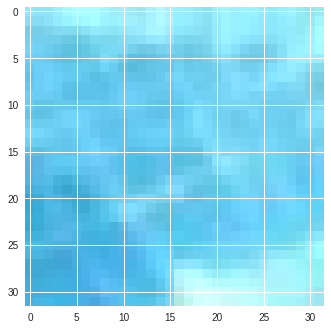

In [0]:
import matplotlib.pyplot as plt

plt.imshow(im)

In [0]:
np.array(im).shape

(32, 32, 3)

In [0]:
np.max(im)

255